In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import xgboost as xgb


In [3]:
matplotlib.rcParams.update({'font.size': 14})

Путь к файлам

In [4]:
TRAIN_DATASET_PATH = "C:/Users/yulia.sheipak/Documents/project_data_from_kaggle/train.csv"
TEST_DATASET_PATH = "C:/Users/yulia.sheipak/Documents/project_data_from_kaggle/test.csv"

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [6]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


Распределение целевой переменной

In [7]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()

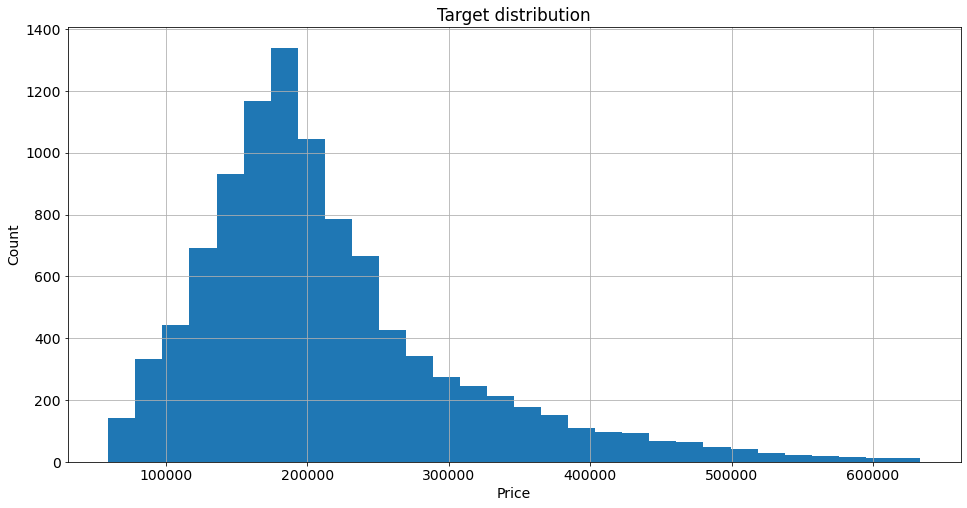

In [8]:
plt.figure(figsize = (16, 8)) 

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')
plt.title('Target distribution')
plt.show() #нормальное распределение

# как отразить еще линии

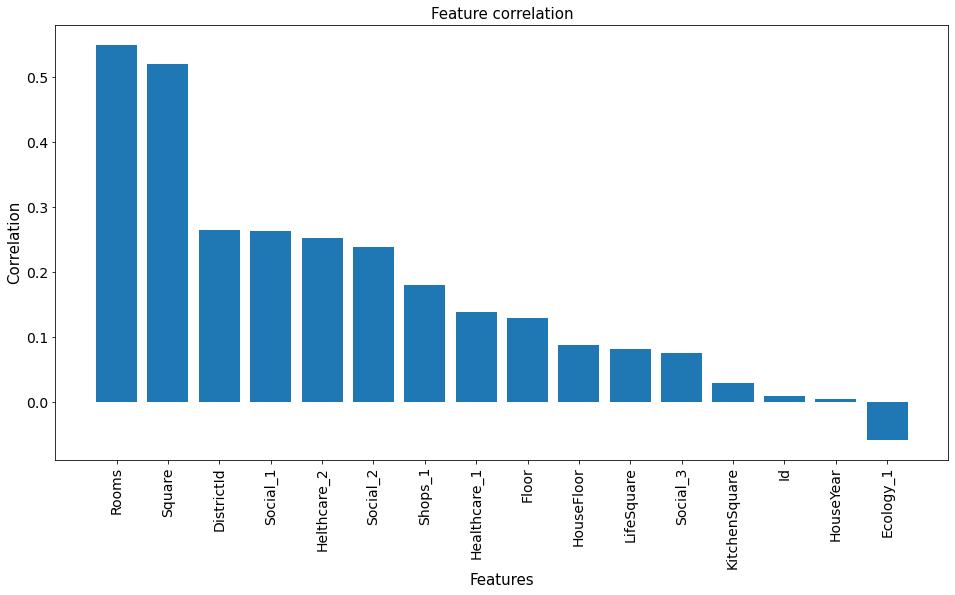

In [9]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

Приведение типов

In [10]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [11]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [12]:
test_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [13]:
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

In [14]:
train_df['Id'] = train_df['Id'].astype(str)
test_df['Id'] = test_df['Id'].astype(str)

Количественные переменные

In [15]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [16]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [17]:
df_num_features = train_df.select_dtypes(include=['float64', 'float32', 'float16', "int64"])
df_num_features.drop('Price', axis=1, inplace=True)

In [18]:
df_num_features

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
0,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,11,3097,0,NaN,0,0
1,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0
2,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,3,1
3,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,1,264,0,NaN,0,1
4,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,33,8667,2,NaN,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,52,10311,6,NaN,1,9
9996,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,2,629,1,NaN,0,0
9997,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,20,4386,14,NaN,1,5
9998,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,47,8004,3,125.0,3,5


array([[<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'LifeSquare'}>,
        <AxesSubplot:title={'center':'KitchenSquare'}>],
       [<AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'HouseYear'}>,
        <AxesSubplot:title={'center':'Ecology_1'}>],
       [<AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>,
        <AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Healthcare_1'}>],
       [<AxesSubplot:title={'center':'Helthcare_2'}>,
        <AxesSubplot:title={'center':'Shops_1'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

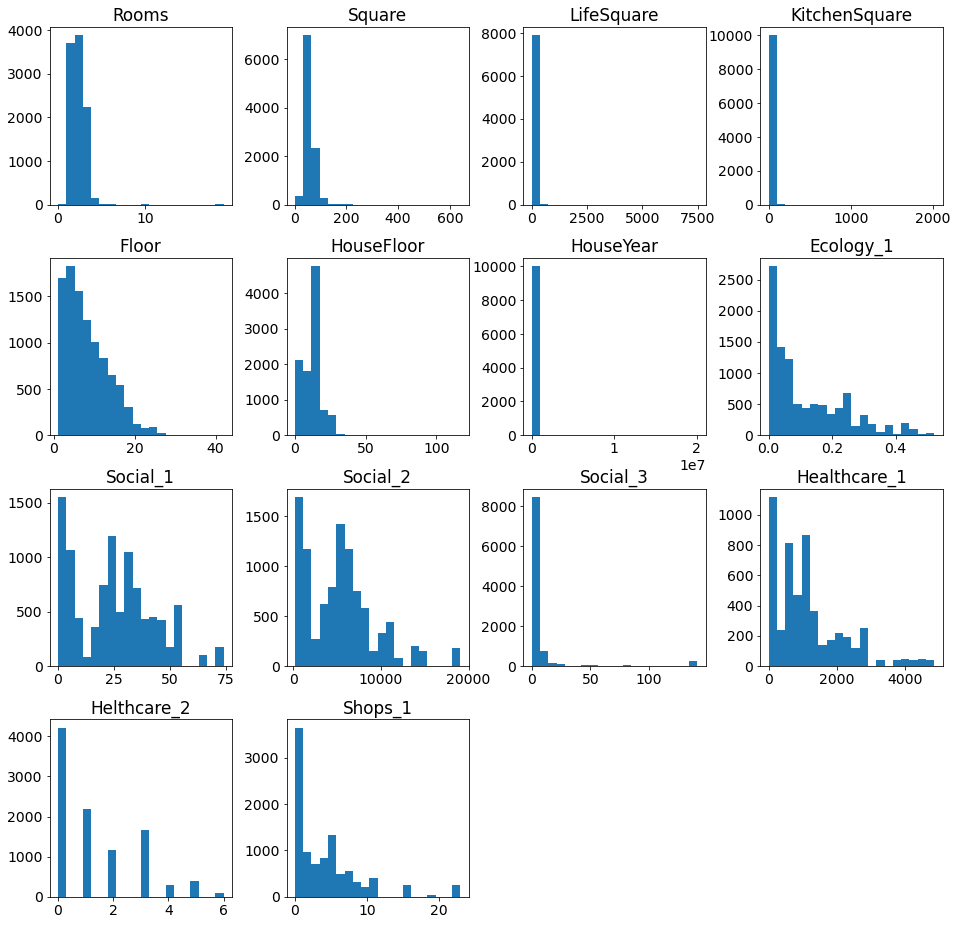

In [19]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False)

Подготовка данных в реальном проекте

In [20]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.mode = None
        self.room_max_value = None
        self.room_min_value = None
        self.sq_max_value = None
        self.sq_min_value = None
        self.lsq_max_value = None
        self.lsq_min_value = None
        self.ksq_max_value = None
        self.ksq_min_value = None
        self.hc1_max_value = None
        self.hc1_min_value = None
        self.floor_mode = None
        self.hfloor_mode = None
        self.median_life_square_share = None
        self.med_price_per_sq_by_district = None
        self.districts_density = None
        self.median_MedPrice_SqByDistrict =None
        self.median_density = None
        

        
    def fit(self, X, y):
        """Сохранение статистик"""
        self.medians = X.median()
        self.room_max_value =  np.quantile(X['Rooms'], q=0.999)
        self.room_min_value =  np.quantile(X['Rooms'], q=0.001)
        self.sq_max_value = np.quantile(X['Square'], q=0.999)
        self.sq_min_value = np.quantile(X["Square"], q =0.001)
        self.lsq_max_value = np.quantile(X['LifeSquare'], q=0.999)
        self.lsq_min_value = np.quantile(X['LifeSquare'], q=0.001)
        self.ksq_max_value = np.quantile(X['KitchenSquare'], q=0.999)
        self.ksq_min_value = np.quantile(X['KitchenSquare'], q=0.001)
        self.hc1_max_value = np.quantile(X['Healthcare_1'], q=0.999)
        self.hc1_min_value = np.quantile(X['Healthcare_1'], q=0.001)
        self.floor_max_value = np.quantile(X['Floor'], q=0.999)
        self.floor_min_value = np.quantile(X['Floor'], q=0.001) 
        self.hfloor_max_value = np.quantile(X['HouseFloor'], q=0.999)
        self.hfloor_min_value = np.quantile(X['HouseFloor'], q=0.001)                                   
        self.floor_mode = X["Floor"].mode()[0]
        self.hfloor_mode = X["HouseFloor"].mode()[0]
        X['life_square_share'] = X['LifeSquare'] / X['Square']
        self.median_life_square_share = X['life_square_share'].median()
        X["price_per_sq"]=  y / X['Square']
        self.med_price_per_sq_by_district = X.groupby(["DistrictId"], as_index=False).agg({'price_per_sq':'median'})\
                                            .rename(columns={'price_per_sq':'MedPrice_SqByDistrict'})
        self.districts_density = X.groupby(["DistrictId"], as_index=False).agg({'Square':'median'})\
                                            .rename(columns={'Square':'DistrictDensity'})
        self.median_MedPrice_SqByDistrict =  X["price_per_sq"].median()
        self.median_density = X["Square"].median()



        
    def transform(self, X):
        """Трансформация данных"""
        # 1. Пропуски
        #LifeSquare
        X['LifeSquare'].fillna(self.medians['LifeSquare'], inplace=True)
        
        #HealthCare_1
        X['Healthcare_1'].fillna(self.medians['Healthcare_1'], inplace=True)

        # HouseFloor
        X['HouseFloor'].fillna(self.hfloor_mode, inplace=True)       
        X.loc[(X['HouseFloor'] == 0), 'HouseFloor'] = self.hfloor_mode
        

        
        # 2. Выбросы (outliers)
        
        #Rooms
        X.loc[(X['Rooms'] > self.room_max_value) | (X['Rooms'] < self.room_min_value), 'Rooms'] = self.medians['Rooms']
        
        # Square
        X.loc[(X['Square'] > self.sq_max_value) | (X['Square'] < self.sq_min_value), 'Square'] = self.medians['Square']
        
        # LifeSquare
        X.loc[(X['LifeSquare'] >  self.lsq_max_value ) | (X['LifeSquare'] < self.lsq_min_value ), 'LifeSquare'] = self.medians['LifeSquare']
        
        #KitchenSquare
        X.loc[(X['KitchenSquare'] > self.ksq_max_value ) | (X['KitchenSquare'] < self.ksq_min_value), 'KitchenSquare'] = self.medians['KitchenSquare']
        
        ## общая площадт не может быть больше жилой, проверим, есть ли такие случаи, высчитаем медиану доли жилой в общей площади, и с помощью этого показателя
        # найдем новое значение жилой площади
        X.loc[( X["Square"] <= X["LifeSquare"]), 'LifeSquare'] = X['Square'] * self.median_life_square_share
        
        # сумма площади кухни и жилой площади не может быть больше общей площади
        X.loc[(X["Square"] < (X["LifeSquare"] + X["KitchenSquare"])), 'LifeSquare'] = X['Square'] * self.median_life_square_share
        
        #Floor
        X.loc[(X['Floor'] > self.floor_max_value) | (X['Floor'] < self.floor_min_value), 'Floor'] = self.floor_mode
        #HouseFloor
        X.loc[(X['HouseFloor'] > self.hfloor_max_value) | (X['HouseFloor'] < self.hfloor_min_value), 'HouseFloor'] = self.hfloor_mode
        
        # обработка условия, когда этаж больше этажности дома
        condition = (X['Floor'] > X['HouseFloor'])
        X.loc[condition, 'Floor'], X.loc[condition, 'HouseFloor'] = X.loc[condition, 'HouseFloor'], X.loc[condition, 'Floor'] 
        
        #HouseYear
        X["HouseYear"].replace(to_replace = 4968, value = 1968,inplace=True)
        X["HouseYear"].replace(to_replace = 20052011, value = 2011,inplace=True) 
        
        #Healthcare_1
        X.loc[(X['Healthcare_1'] > self.hc1_max_value) | (X['Healthcare_1'] < self.hc1_min_value ), 'Healthcare_1']  = self.medians['Healthcare_1'] 
        
        

        
        # 3. Новые фичи (features)
        
        #Ecology_1
        eco1_by_district = X.groupby(['DistrictId'], as_index=False).agg({'Ecology_1':'median'})\
                       .rename(columns={'Ecology_1':'Eco_1ByDistrict'})
        X = X.merge(eco1_by_district, on=['DistrictId'], how='left')
        
        ##Social_1
        soc1_by_district = X.groupby(['DistrictId'], as_index=False).agg({'Social_1':'median'})\
                       .rename(columns={'Social_1':'Soc_1ByDistrict'})
        X = X.merge(soc1_by_district, on=['DistrictId'], how='left')

        ##Social_2
        soc2_by_district = X.groupby(['DistrictId'], as_index=False).agg({'Social_2':'median'})\
                       .rename(columns={'Social_2':'Soc_2ByDistrict'})
        X = X.merge(soc2_by_district, on=['DistrictId'], how='left')
               
         ##Social_3
        soc3_by_district = X.groupby(['DistrictId'], as_index=False).agg({'Social_3':'median'})\
                       .rename(columns={'Social_3':'Soc_3ByDistrict'})
        X = X.merge(soc3_by_district, on=['DistrictId'], how='left')
               

        
        #DistrictSize
        district_size = X['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        X = X.merge(district_size, on='DistrictId', how='left')
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        #IsNew
        X['IsNew'] = (X['HouseYear'] > 2012).astype(int)
               
        #IsOld
        X['IsOld'] = (X['HouseYear'] < 1941).astype(int)
              
        #floor cat
    
        X['floor_cat'] = 0

        X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 15), 'floor_cat'] = 3
        X.loc[X['Floor'] > 15, 'floor_cat'] = 4
        
        #MedPrice_SqByDistrict
        if self.med_price_per_sq_by_district is not None:
            X = X.merge(self.med_price_per_sq_by_district , on=['DistrictId'], how='left')
            X['MedPrice_SqByDistrict'].fillna(self.median_MedPrice_SqByDistrict, inplace=True)       

       
        #district_cat
        X['district_cat'] = 0

        X.loc[X['MedPrice_SqByDistrict'] <= 3000, 'district_cat'] = 1  
        X.loc[(X['MedPrice_SqByDistrict'] > 3000) & (X['MedPrice_SqByDistrict'] <= 4500), 'district_cat'] = 2
        X.loc[(X['MedPrice_SqByDistrict'] > 4500) & (X['MedPrice_SqByDistrict'] <= 6000), 'district_cat'] = 3
        X.loc[(X['MedPrice_SqByDistrict'] > 6000) & (X['MedPrice_SqByDistrict'] <= 8000), 'district_cat'] = 4
        X.loc[X['MedPrice_SqByDistrict'] > 8000, 'district_cat'] = 5
        
        #DistrictDensity
        X = X.merge(self.districts_density, on=['DistrictId'], how='left')
        X['DistrictDensity'].fillna(self.median_density, inplace=True)       
        
        # 4. Обработка категорий
        X = pd.concat([X, pd.get_dummies(X['Ecology_2'])], axis=1)
        X.rename(columns={"A": "Ecology_2A", "B": "Ecology_2B"}, inplace = True)
        X = pd.concat([X, pd.get_dummies(X['Ecology_3'])], axis=1)
        X.rename(columns={"A": "Ecology_3A", "B": "Ecology_3B"}, inplace = True)
        X = pd.concat([X, pd.get_dummies(X['Shops_2'])], axis=1)
        X.rename(columns={"A": "Shops_2A", "B": "Shops_2B"}, inplace = True)
        
        # Drop Id
        X.drop(['Id'], axis=1, inplace=True)
        
         # Drop DistrictId
        X.drop(['DistrictId'], axis=1, inplace=True)

 
        return X

In [21]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 
                 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3','Helthcare_2', 'Shops_1']

new_feature_names = ['Eco_1ByDistrict', 
                     'DistrictSize', 'IsDistrictLarge', 'Shops_2A', 'MedPrice_SqByDistrict',
                     'Shops_2B', 'Soc_1ByDistrict','Soc_2ByDistrict', 'Soc_3ByDistrict', 'floor_cat', 'district_cat', 'DistrictDensity']
all_features = feature_names + new_feature_names

target_name = 'Price'

In [22]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)
X = train_df
X = train_df.drop(columns=["Price"])
y = train_df["Price"]

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [24]:
preprocessor = DataPipeline()
preprocessor.fit(X_train, y_train)


X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

In [25]:
X_train.shape, X_valid.shape, test_df.shape

((6700, 37), (3300, 35), (5000, 35))

In [26]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(1416, 0, 0)

In [27]:
X_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,floor_cat,MedPrice_SqByDistrict,district_cat,DistrictDensity,Ecology_2A,Ecology_2B,Ecology_3A,Ecology_3B,Shops_2A,Shops_2B
count,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,...,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000
mean,1.891493,56.028827,33.255728,5.813284,7.912090,13.627910,1984.820448,0.119933,24.778209,5379.070000,...,2.469254,3926.120745,2.042985,53.344346,0.009254,0.990746,0.028358,0.971642,0.084328,0.915672
std,0.808053,18.427413,12.894247,4.565710,5.190292,5.760863,18.295557,0.119618,17.629568,4033.819223,...,0.952261,1001.235812,0.802446,6.287981,0.095757,0.095757,0.166006,0.166006,0.277900,0.277900
min,1.000000,16.547242,0.370619,0.000000,1.000000,1.000000,1912.000000,0.000000,0.000000,168.000000,...,1.000000,1271.634986,1.000000,33.533077,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,41.980489,24.239214,1.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,...,2.000000,2892.425405,1.000000,48.042880,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,2.000000,52.621164,32.679351,6.000000,7.000000,14.000000,1977.000000,0.075779,25.000000,5285.000000,...,3.000000,4108.916558,2.000000,53.499357,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,2.000000,65.713217,37.781689,9.000000,11.000000,17.000000,2001.000000,0.195781,36.000000,7287.000000,...,3.000000,4568.302198,3.000000,58.580955,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,5.000000,185.906396,161.155275,73.000000,28.000000,40.000000,2020.000000,0.521867,74.000000,19083.000000,...,4.000000,8700.768533,5.000000,83.883498,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
X_train.isna().sum()

Rooms                       0
Square                      0
LifeSquare                  0
KitchenSquare               0
Floor                       0
HouseFloor                  0
HouseYear                   0
Ecology_1                   0
Ecology_2                   0
Ecology_3                   0
Social_1                    0
Social_2                    0
Social_3                    0
Healthcare_1                0
Helthcare_2                 0
Shops_1                     0
Shops_2                     0
life_square_share        1416
price_per_sq                0
Eco_1ByDistrict             0
Soc_1ByDistrict             0
Soc_2ByDistrict             0
Soc_3ByDistrict             0
DistrictSize                0
IsDistrictLarge             0
IsNew                       0
IsOld                       0
floor_cat                   0
MedPrice_SqByDistrict       0
district_cat                0
DistrictDensity             0
Ecology_2A                  0
Ecology_2B                  0
Ecology_3A

In [29]:
test_df.isna().sum()

Rooms                    0
Square                   0
LifeSquare               0
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1             0
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Eco_1ByDistrict          0
Soc_1ByDistrict          0
Soc_2ByDistrict          0
Soc_3ByDistrict          0
DistrictSize             0
IsDistrictLarge          0
IsNew                    0
IsOld                    0
floor_cat                0
MedPrice_SqByDistrict    0
district_cat             0
DistrictDensity          0
Ecology_2A               0
Ecology_2B               0
Ecology_3A               0
Ecology_3B               0
Shops_2A                 0
Shops_2B                 0
dtype: int64

In [30]:
test_df.isna().sum()

Rooms                    0
Square                   0
LifeSquare               0
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1             0
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Eco_1ByDistrict          0
Soc_1ByDistrict          0
Soc_2ByDistrict          0
Soc_3ByDistrict          0
DistrictSize             0
IsDistrictLarge          0
IsNew                    0
IsOld                    0
floor_cat                0
MedPrice_SqByDistrict    0
district_cat             0
DistrictDensity          0
Ecology_2A               0
Ecology_2B               0
Ecology_3A               0
Ecology_3B               0
Shops_2A                 0
Shops_2B                 0
dtype: int64

In [31]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [32]:
X_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,IsDistrictLarge,Shops_2A,MedPrice_SqByDistrict,Shops_2B,Soc_1ByDistrict,Soc_2ByDistrict,Soc_3ByDistrict,floor_cat,district_cat,DistrictDensity
count,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,...,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000
mean,1.891493,56.028827,33.255728,5.813284,7.912090,13.627910,1984.820448,0.119933,24.778209,5379.070000,...,0.387761,0.084328,3926.120745,0.915672,24.301045,5225.622687,7.758060,2.469254,2.042985,53.344346
std,0.808053,18.427413,12.894247,4.565710,5.190292,5.760863,18.295557,0.119618,17.629568,4033.819223,...,0.487276,0.277900,1001.235812,0.277900,17.242163,3937.554235,23.091712,0.952261,0.802446,6.287981
min,1.000000,16.547242,0.370619,0.000000,1.000000,1.000000,1912.000000,0.000000,0.000000,168.000000,...,0.000000,0.000000,1271.634986,0.000000,1.000000,264.000000,0.000000,1.000000,1.000000,33.533077
25%,1.000000,41.980489,24.239214,1.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,...,0.000000,0.000000,2892.425405,1.000000,5.000000,1564.000000,0.000000,2.000000,1.000000,48.042880
50%,2.000000,52.621164,32.679351,6.000000,7.000000,14.000000,1977.000000,0.075779,25.000000,5285.000000,...,0.000000,0.000000,4108.916558,1.000000,25.000000,5258.500000,1.000000,3.000000,2.000000,53.499357
75%,2.000000,65.713217,37.781689,9.000000,11.000000,17.000000,2001.000000,0.195781,36.000000,7287.000000,...,1.000000,0.000000,4568.302198,1.000000,35.000000,7065.000000,5.000000,3.000000,3.000000,58.580955
max,5.000000,185.906396,161.155275,73.000000,28.000000,40.000000,2020.000000,0.521867,74.000000,19083.000000,...,1.000000,1.000000,8700.768533,1.000000,74.000000,19083.000000,141.000000,4.000000,5.000000,83.883498


In [33]:
features_to_stand = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [34]:
scaler = RobustScaler()
X_train[features_to_stand] = pd.DataFrame(scaler.fit_transform(X_train[features_to_stand]), columns=features_to_stand)
test_df[features_to_stand] = pd.DataFrame(scaler.transform(test_df[features_to_stand]), columns=features_to_stand)
X_valid[features_to_stand] = pd.DataFrame(scaler.fit_transform(X_valid[features_to_stand]), columns=features_to_stand)

In [35]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
   
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Linear Regression

In [36]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_preds = lr_model.predict(X_train)
# Постпроцессинг
y_train_preds = np.clip(y_train_preds, a_min=10000, a_max=500000)

Train R2:	0.693
Test R2:	0.668


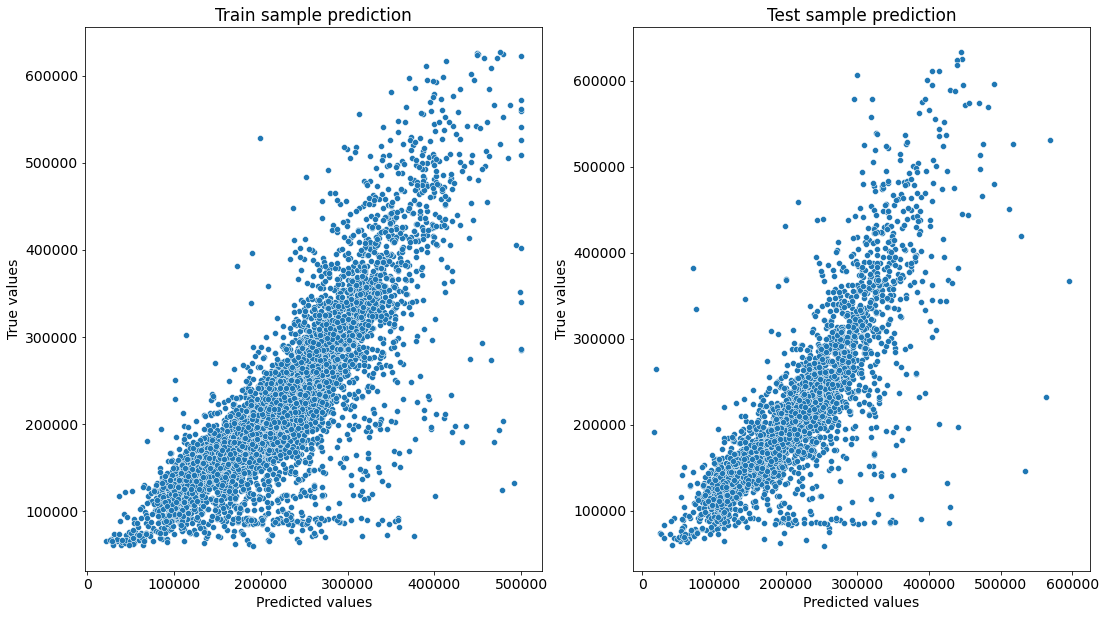

In [37]:
y_test_preds = lr_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [38]:
cv_score = cross_val_score(lr_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.71942273, 0.65107886, 0.689814  ])

In [39]:
cv_score.mean()

0.6867718619666984

RandomForestRegressor

In [40]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', random_state=21)

Train R2:	0.963
Test R2:	0.734


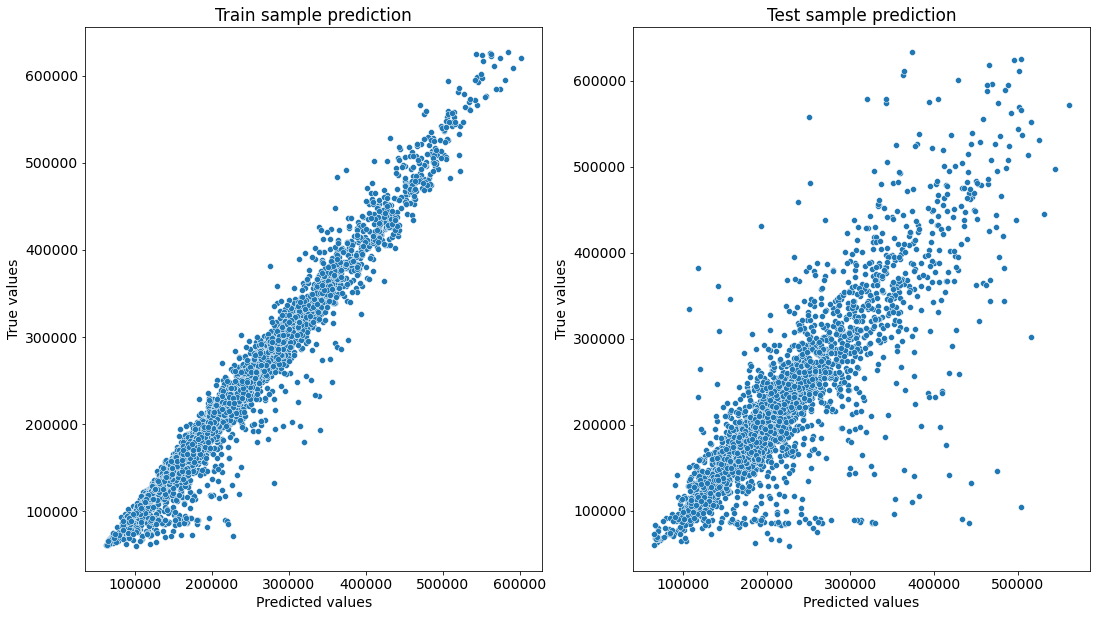

In [41]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [42]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.75788371, 0.69072501, 0.74443965])

In [43]:
cv_score.mean()

0.7310161227772273

In [44]:
importances = rf_model.feature_importances_
importances

array([2.83994121e-02, 4.17815056e-01, 2.58583020e-02, 1.91488963e-02,
       1.77866335e-02, 2.14664628e-02, 2.48074125e-02, 1.20846143e-02,
       1.12817102e-02, 1.32685175e-02, 8.33596117e-03, 6.52254095e-03,
       8.74459323e-03, 6.86106340e-03, 8.20040239e-03, 2.55662716e-04,
       6.30181603e-04, 3.29868673e-01, 5.28600947e-04, 5.76045028e-03,
       5.65140854e-03, 6.93943827e-03, 3.85705172e-03, 4.63648912e-03,
       1.12904657e-02])

In [45]:
sum_imp = importances.sum()
sum_imp

1.0

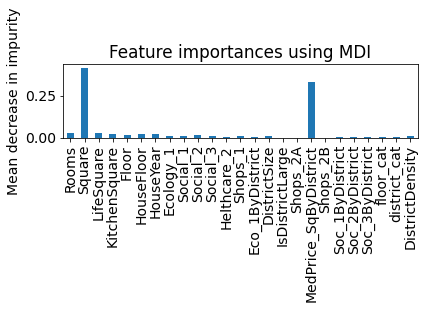

In [46]:
forest_importances = pd.Series(importances, index=(feature_names + new_feature_names))
fig, ax = plt.subplots()
forest_importances.plot.bar()
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

DecisionTreeRegressor

In [47]:
dt_model = DecisionTreeRegressor(criterion='mse', 
                                 max_depth=400, # глубина дерева  
                                 min_samples_leaf=1, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42)
dt_model.fit(X_train, y_train)

y_train_preds = dt_model.predict(X_train)
y_test_preds =  dt_model.predict(X_valid)

Train R2:	1.0
Test R2:	0.509


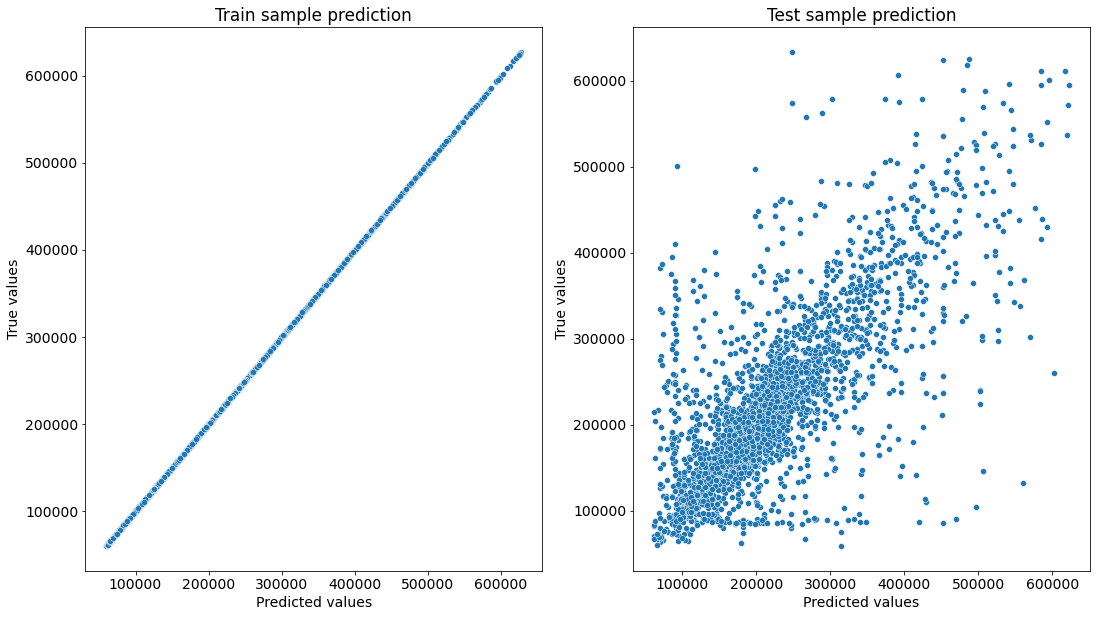

In [48]:
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [49]:
cv_score = cross_val_score(dt_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.51306326, 0.37926355, 0.43819091])

In [50]:
cv_score.mean()

0.4435059049367192

Gradient Boosting decision trees

Train R2:	0.909
Test R2:	0.749


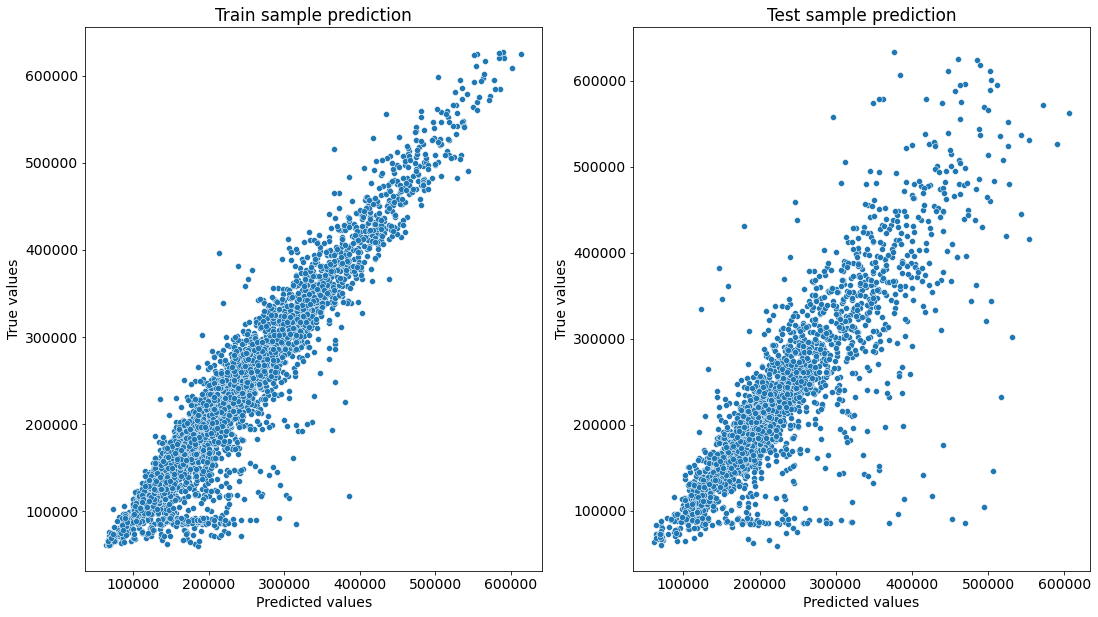

In [51]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_test_preds =  gb_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [52]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))

In [53]:
cv_score.mean()

0.7358239478391804

In [54]:
importances = gb_model.feature_importances_
importances

array([2.96794122e-02, 4.35063508e-01, 1.76874704e-02, 1.53687478e-02,
       1.13964643e-02, 1.55166616e-02, 2.32413046e-02, 1.24058857e-02,
       1.05826976e-02, 1.00186174e-02, 7.75993783e-03, 5.76262417e-03,
       6.24688253e-03, 6.08531853e-03, 7.95804080e-03, 4.54876229e-06,
       2.31317003e-04, 3.53716435e-01, 2.46984511e-05, 4.79334896e-03,
       5.66936577e-03, 5.38890878e-03, 1.40181893e-03, 4.86555462e-03,
       9.13043023e-03])

In [55]:
sum_imp = importances.sum()
sum_imp

1.0

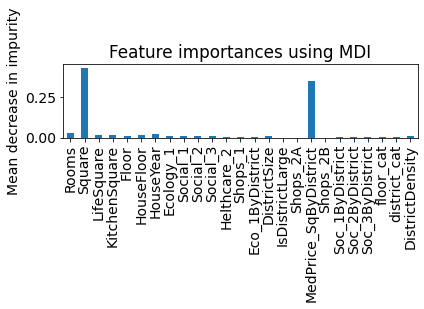

In [56]:
forest_importances = pd.Series(importances, index=(feature_names + new_feature_names))
fig, ax = plt.subplots()
forest_importances.plot.bar()
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

XGBRegressor

Train R2:	0.926
Test R2:	0.756


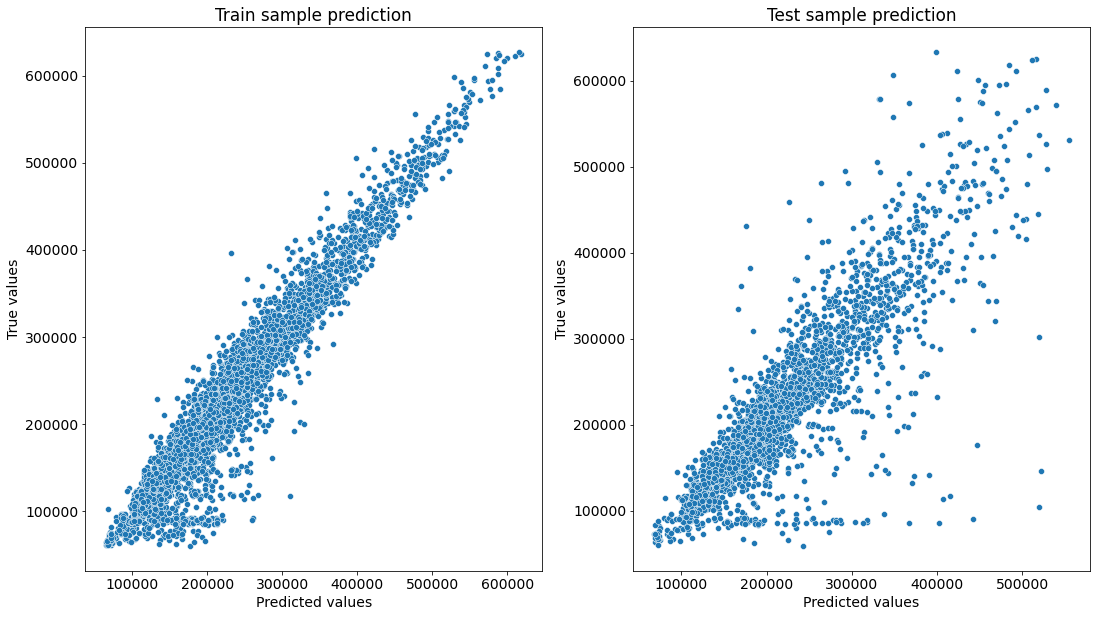

In [57]:
xgbr_model = xgb.XGBRegressor(colsample_bytree=0.4445, 
                             learning_rate=0.015, max_depth=6,
                             min_child_weight=0.1, 
                             n_estimators=1000,
                             reg_lambda=0.6,
                             random_state =7)
xgbr_model.fit(X_train, y_train)

y_train_preds = xgbr_model.predict(X_train)
y_test_preds = xgbr_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)


In [58]:
cv_score = cross_val_score(xgbr_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))

In [59]:
cv_score.mean()

0.7420593095923871

Предсказаний

In [60]:
submit = pd.read_csv('C:/Users/yulia.sheipak/Documents/project_data_from_kaggle/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [61]:
predictions = gb_model.predict(test_df)
predictions

array([172118.09810362, 121121.23617689, 147239.7340981 , ...,
       150170.76642314, 193486.28706585, 255607.17688844])

In [62]:
test_df.isna().sum()

Rooms                    0
Square                   0
LifeSquare               0
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Social_1                 0
Social_2                 0
Social_3                 0
Helthcare_2              0
Shops_1                  0
Eco_1ByDistrict          0
DistrictSize             0
IsDistrictLarge          0
Shops_2A                 0
MedPrice_SqByDistrict    0
Shops_2B                 0
Soc_1ByDistrict          0
Soc_2ByDistrict          0
Soc_3ByDistrict          0
floor_cat                0
district_cat             0
DistrictDensity          0
dtype: int64

In [63]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,172118.098104
1,5925,121121.236177
2,960,147239.734098
3,3848,109198.837459
4,746,181248.927613


In [64]:
submit.shape

(5000, 2)

In [66]:
submit.to_csv('C:/Users/yulia.sheipak/Documents/model_submit.csv', index=False)